In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from keras.models import Sequential
from keras.layers import Dense, LSTM ,Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


#### data불러오기

In [2]:
data=pd.read_csv('data/samsung.csv')
print(data.shape)
data=data.dropna().reset_index()
print(data.shape)

(732, 7)
(721, 8)


In [3]:
data.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2017-01-17,36580.0,37460.0,36580.0,36960.0,7811.878418,8150700.0
1,1,2017-01-18,37040.0,37500.0,36620.0,36940.0,7807.651367,8875400.0
2,2,2017-01-19,37720.0,37920.0,37020.0,37480.0,7921.786133,9418900.0
3,3,2017-01-20,37120.0,37420.0,36880.0,37200.0,7862.604004,9185000.0
4,4,2017-01-23,37200.0,38060.0,37000.0,38060.0,8044.374512,8810400.0


#### 기술적 지표 추가

In [4]:
class sumin():
    
    def __init__(self):
        self.data = data

    @staticmethod
    def bollinger_band(data, w=20, k=2):

        data=data['Close']
        mbb = data.rolling(w).mean()
        ubb = mbb + k * data.rolling(w).std()
        lbb = mbb - k * data.rolling(w).std()
        result = np.array([data,mbb,ubb,lbb])

        df = pd.DataFrame(result).T
        df.columns = ["close", "mbb", "ubb", "lbb"]

        return df
    
    
    @staticmethod
    def moving_average(data, w=5):
        
        data=data['Close']
        ma_w=data.ewm(span=w).mean()
        ma_5=data.ewm(span=5).mean()
        ma_10=data.ewm(span=10).mean()
        ma_15=data.ewm(span=15).mean()
        ma_20=data.ewm(span=20).mean()
        ma_30=data.ewm(span=30).mean()
        ma_60=data.ewm(span=60).mean()

        result = np.array([data,ma_w,ma_5,ma_10,ma_15,ma_20,ma_30,ma_60])

        df = pd.DataFrame(result).T
        df.columns = ["close", "user_ma_{}".format(w), "ma_5", "ma_10","ma_15","ma_20","ma_30","ma_60" ]

        if w == 5:
            del df['user_ma_5']

        return df
    
    
    @staticmethod
    def macd(data, fast=12, slow=26, signal=9) :

        data=data['Close']
        fast = data.ewm(span=fast).mean() 
        slow = data.ewm(span=slow).mean() 
        macd = fast - slow 
        signal = macd.ewm(span=signal).mean() 
        osc = macd - signal 

        result = np.array([data,macd,fast,slow, signal,osc])
        df = pd.DataFrame(result).T
        df.columns = ["close", "macd", "fast", "slow","signal","osc"]

        return df
    
    @staticmethod
    def rsi(data, length=14):

        data=data['Close']
        delta = data.diff()
        delta = delta[1:]
        up, down = delta.copy(), delta.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        roll_up1 = up.ewm(com=(length-1), min_periods=length).mean()
        roll_down1 = down.abs().ewm(com=(length-1), min_periods=length).mean()

        RSI_1 = roll_up1 / roll_down1
        RSI = 100.0 - (100.0 / (1.0 + RSI_1))

        df = pd.DataFrame([data,RSI]).T
        df.columns = ["close", "rsi"]

        return df
    
    
    @staticmethod
    def stochastic(data, n=15, m=5, t=3):

        high = data.High.rolling(window=n, min_periods=1).max()
        low = data.Low.rolling(window=n, min_periods=1).min()

        fast_K = ((data.Close - low) / (high - low))*100
        fast_D = fast_K.ewm(span=m).mean()
        Slow_D = fast_D.ewm(span=t).mean()

        df = pd.DataFrame([data['Close'],data['Open'],data['High'],data['Low'],fast_K,fast_D,Slow_D]).T
        df.columns = ["close",'open','high','low', "fast_K",'fast_D','slow_D']

        return df

    @staticmethod
    def roc(data,n=5):
        
        N = data['Close'].diff(n)
        D = data['Close'].shift(n)
        ROC = pd.Series(N/D,name='ROC')

        df = pd.DataFrame([data['Close'],ROC]).T
        df.columns = ["close", "roc"]
        
        return df

In [5]:
sumin=sumin()
bb=sumin.bollinger_band(data)
ma=sumin.moving_average(data)
macd=sumin.macd(data)
rsi=sumin.rsi(data)
sto=sumin.stochastic(data)
roc=sumin.roc(data)

In [6]:
bb.shape, ma.shape, macd.shape, rsi.shape, sto.shape, roc.shape

((721, 4), (721, 7), (721, 6), (721, 2), (721, 7), (721, 2))

####  dataframe 만들기, na값 제거

In [7]:
data_1=pd.merge(bb,ma, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,macd, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,rsi, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,sto, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,roc, how='outer', left_index=True, right_index=True)

#include date
df=pd.merge(data_1, data['Date'],left_on=None, right_on=None, left_index=True, right_index=True)

In [8]:
df = df[['Date','mbb','ubb','lbb','ma_5','ma_10','ma_15','ma_20','ma_30','ma_60','macd','fast','slow','signal',
                   'osc','rsi','open','high','low','fast_K','fast_D','slow_D','roc']]

print(df.shape)
df.head()

(721, 23)


,Date,mbb,ubb,lbb,ma_5,ma_10,ma_15,ma_20,ma_30,ma_60,...,signal,osc,rsi,open,high,low,fast_K,fast_D,slow_D,roc
0,2017-01-17,NaN,NaN,NaN,36960.00000,36960.000000,36960.000000,36960.000000,36960.000000,36960.000000,...,0.000000,0.000000,NaN,36580.0,37460.0,36580.0,43.181818,43.181818,43.181818,NaN
1,2017-01-18,NaN,NaN,NaN,36948.00000,36949.000000,36949.333333,36949.500000,36949.666667,36949.833333,...,-0.249288,-0.199430,NaN,37040.0,37500.0,36620.0,39.130435,40.750988,41.561265,NaN
2,2017-01-19,NaN,NaN,NaN,37200.00000,37162.458472,37150.295858,37144.296420,37138.356164,37132.478474,...,6.481409,9.692203,NaN,37720.0,37920.0,37020.0,67.164179,53.262500,48.247685,NaN
3,2017-01-20,NaN,NaN,NaN,37200.00000,37174.826733,37165.309735,37160.377182,37155.341287,37150.212094,...,8.766875,4.461231,NaN,37120.0,37420.0,36880.0,46.268657,50.357365,49.372847,NaN
4,2017-01-23,NaN,NaN,NaN,37530.14218,37428.935903,37394.910093,37377.988286,37361.173047,37344.498887,...,19.715109,25.855348,NaN,37200.0,38060.0,37000.0,100.000000,69.414490,59.716921,NaN


#### data 전처리

In [9]:
df=df.dropna()
print(df.shape)
df.head()

(702, 23)


,Date,mbb,ubb,lbb,ma_5,ma_10,ma_15,ma_20,ma_30,ma_60,...,signal,osc,rsi,open,high,low,fast_K,fast_D,slow_D,roc
19,2017-02-15,38415.0,40275.927895,36554.072105,37990.698549,38280.522555,38384.153558,38422.070516,38443.055695,38441.813445,...,43.756182,-147.316867,44.042066,37080.0,37960.0,37080.0,21.917808,34.048228,41.371132,-0.017708
20,2017-02-16,38468.0,40211.095854,36724.904146,38000.467658,38232.443934,38335.700138,38378.445246,38406.834335,38414.342923,...,11.741611,-126.581872,48.808410,37800.0,38360.0,37780.0,32.191781,33.429288,37.400208,-0.009896
21,2017-02-17,38514.0,40131.332437,36896.667563,37953.638846,38163.897615,38272.910527,38322.929469,38360.982816,38379.372319,...,-17.409180,-115.527689,46.531958,37560.0,38040.0,37280.0,26.712329,31.190003,34.295105,-0.013034
22,2017-02-20,38573.0,40115.889975,37030.110025,38189.113546,38254.999775,38323.649182,38358.600947,38385.579585,38396.555055,...,-32.223851,-58.821431,57.264594,38220.0,38780.0,38160.0,56.028369,39.470196,36.882650,0.018440
23,2017-02-21,38660.0,40067.169612,37252.830388,38439.423900,38380.562116,38403.950782,38419.484461,38430.390436,38428.909744,...,-33.421788,-4.763464,60.270516,38540.0,39560.0,38420.0,72.093023,50.345118,43.613884,0.036189


#### df 정규화 시키기

In [10]:
temp_df = df[df.columns[1:]]
sc = MinMaxScaler()
temp_df = sc.fit_transform(temp_df)
nor_df = pd.DataFrame(temp_df, columns=df.columns[1:])
nor_df.columns=[i for i in df.columns[1:]]
print(nor_df.shape)
nor_df.head()

(702, 22)


,mbb,ubb,lbb,ma_5,ma_10,ma_15,ma_20,ma_30,ma_60,macd,...,signal,osc,rsi,open,high,low,fast_K,fast_D,slow_D,roc
0,0.000000,0.021953,0.014929,0.001673,0.005589,0.005592,0.005182,0.004570,0.003998,0.358005,...,0.424791,0.418849,0.338202,0.000000,0.014754,0.009524,0.219178,0.304727,0.380315,0.378231
1,0.002819,0.018952,0.024991,0.002113,0.003285,0.003156,0.002902,0.002553,0.002239,0.354439,...,0.412926,0.434135,0.426595,0.029009,0.031148,0.038509,0.321918,0.297986,0.335974,0.417894
2,0.005266,0.015260,0.035109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348717,...,0.402123,0.442284,0.384378,0.019339,0.018033,0.017805,0.267123,0.273598,0.301301,0.401960
3,0.008404,0.014545,0.042969,0.010627,0.004366,0.002550,0.001865,0.001370,0.001100,0.361962,...,0.396632,0.484089,0.583417,0.045931,0.048361,0.054244,0.560284,0.363778,0.330194,0.561755
4,0.013032,0.012290,0.056089,0.021924,0.010383,0.006587,0.005047,0.003865,0.003172,0.378676,...,0.396188,0.523942,0.639163,0.058824,0.080328,0.065010,0.720930,0.482217,0.405358,0.651865


#### include label. y=close price (10days later). 5 day information -> 5 day later prediction

In [11]:
y = data[["Close"]]
y = y[29:].reset_index() 
# data start 2017-02-15 original index 19
# so y have to start after 10day. index is 29
print(y.shape)
y

(692, 2)


,index,Close
0,29,39720.0
1,30,39620.0
2,31,40080.0
3,32,40200.0
4,33,40200.0
...,...,...
687,716,60000.0
688,717,60000.0
689,718,59000.0
690,719,60700.0


In [12]:
scale_y=y['Close'].as_matrix().reshape(-1, 1)

sc_y = MinMaxScaler()

nor_y = sc_y.fit_transform(scale_y)

nor_y=pd.DataFrame(nor_y)
nor_y.columns=['y']
nor_y=np.array(nor_y)
print(nor_y.shape)

(692, 1)


C:\Users\wsm26\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


#### 5일씩 묶어주기

In [13]:
d_matrix=nor_df.as_matrix()

p_result =[]
for i in range(len(nor_df)-10):
    for j in range(5):
        p_result.append(d_matrix[i+j])

C:\Users\wsm26\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [14]:
p_result=np.array(p_result)
p_result=p_result.reshape((len(d_matrix)-10,5,len(nor_df.columns)))
p_result

array([[[0.        , 0.02195262, 0.01492851, ..., 0.30472713,
         0.38031463, 0.37823095],
        [0.00281915, 0.01895172, 0.02499132, ..., 0.29798622,
         0.33597361, 0.41789423],
        [0.00526596, 0.01525969, 0.035109  , ..., 0.27359803,
         0.3013007 , 0.40195999],
        [0.00840426, 0.0145449 , 0.04296939, ..., 0.36377808,
         0.33019434, 0.56175475],
        [0.01303191, 0.01228976, 0.05608867, ..., 0.48221746,
         0.40535816, 0.65186463]],

       [[0.00281915, 0.01895172, 0.02499132, ..., 0.29798622,
         0.33597361, 0.41789423],
        [0.00526596, 0.01525969, 0.035109  , ..., 0.27359803,
         0.3013007 , 0.40195999],
        [0.00840426, 0.0145449 , 0.04296939, ..., 0.36377808,
         0.33019434, 0.56175475],
        [0.01303191, 0.01228976, 0.05608867, ..., 0.48221746,
         0.40535816, 0.65186463],
        [0.01632979, 0.01506505, 0.05986105, ..., 0.61183122,
         0.50938553, 0.68079346]],

       [[0.00526596, 0.01525969, 0.0

In [15]:
p_result[0]

array([[0.        , 0.02195262, 0.01492851, 0.00167254, 0.00558907,
        0.0055918 , 0.00518237, 0.00457012, 0.00399808, 0.35800513,
        0.00572765, 0.00477154, 0.42479051, 0.41884881, 0.33820211,
        0.        , 0.0147541 , 0.00952381, 0.21917808, 0.30472713,
        0.38031463, 0.37823095],
       [0.00281915, 0.01895172, 0.02499132, 0.00211343, 0.00328498,
        0.00315621, 0.00290196, 0.00255318, 0.00223915, 0.35443859,
        0.00328272, 0.0026662 , 0.41292587, 0.43413501, 0.4265952 ,
        0.02900886, 0.03114754, 0.03850932, 0.32191781, 0.29798622,
        0.33597361, 0.41789423],
       [0.00526596, 0.01525969, 0.035109  , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.34871656,
        0.        , 0.        , 0.40212255, 0.44228435, 0.38437781,
        0.01933924, 0.01803279, 0.01780538, 0.26712329, 0.27359803,
        0.3013007 , 0.40195999],
       [0.00840426, 0.0145449 , 0.04296939, 0.01062722, 0.00436593,
        0.0025504

#### make train, test set

In [16]:
X_train,X_test = p_result[:int(len(p_result)*0.9)],p_result[int(len(p_result)*0.9):]
y_train,y_test = nor_y[:int(len(p_result)*0.9)],nor_y[int(len(p_result)*0.9):]

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((622, 5, 22), (622, 1), (70, 5, 22), (70, 1))

#### model

In [18]:
model = Sequential()

model.add(LSTM(units=100, input_shape=(5,22)))
model.add(Dense(units=1))
model.add(Dropout(0.1))

#### earlystopping

In [19]:
early_stopping = EarlyStopping(patience=30)

In [20]:
model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=300, batch_size=12, validation_split=0.3, callbacks=[early_stopping])

Train on 435 samples, validate on 187 samples
Epoch 1/300
435/435 [==============================] - 1s 2ms/step - loss: 0.0377 - val_loss: 0.0063
Epoch 2/300
435/435 [==============================] - 0s 563us/step - loss: 0.0331 - val_loss: 0.0092
Epoch 3/300
435/435 [==============================] - 0s 650us/step - loss: 0.0280 - val_loss: 0.0056
Epoch 4/300
435/435 [==============================] - 0s 618us/step - loss: 0.0326 - val_loss: 0.0167
Epoch 5/300
435/435 [==============================] - 0s 618us/step - loss: 0.0244 - val_loss: 0.0068
Epoch 6/300
435/435 [==============================] - 0s 639us/step - loss: 0.0257 - val_loss: 0.0060
Epoch 7/300
435/435 [==============================] - 0s 689us/step - loss: 0.0264 - val_loss: 0.0063
Epoch 8/300
435/435 [==============================] - 0s 689us/step - loss: 0.0288 - val_loss: 0.0074
Epoch 9/300
435/435 [==============================] - 0s 574us/step - loss: 0.0218 - val_loss: 0.0063
Epoch 10/300
435/435 [=======

In [21]:
predicted = model.predict(X_test)

In [22]:
predicted

array([[0.39118248],
       [0.40569174],
       [0.38459262],
       [0.38812038],
       [0.36240777],
       [0.3881796 ],
       [0.39074847],
       [0.3483664 ],
       [0.3589825 ],
       [0.40654537],
       [0.39049467],
       [0.42203087],
       [0.46017733],
       [0.46750948],
       [0.47822654],
       [0.47362643],
       [0.44620112],
       [0.45497823],
       [0.48599383],
       [0.48750314],
       [0.46928924],
       [0.4752834 ],
       [0.4873803 ],
       [0.47856075],
       [0.44793332],
       [0.44954753],
       [0.4687409 ],
       [0.5161983 ],
       [0.5356876 ],
       [0.55854356],
       [0.5506007 ],
       [0.51612467],
       [0.5181416 ],
       [0.5145257 ],
       [0.5500397 ],
       [0.55191827],
       [0.5035236 ],
       [0.45804998],
       [0.47332242],
       [0.47478956],
       [0.46961245],
       [0.4834437 ],
       [0.45565647],
       [0.42084098],
       [0.41782779],
       [0.40248665],
       [0.3929562 ],
       [0.397

In [23]:
RMSE = mean_squared_error(y_test, predicted)**0.5    
print("RMSE =" ,RMSE)
error = y_test - predicted.reshape(1,-1)
print("std ={}" .format(np.std(error)))

RMSE = 0.19156382527348761
std =0.15664196404131028


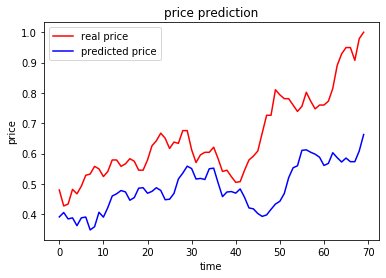

In [24]:
plt.plot(y_test, color="red", label="real price")
plt.plot(predicted, color="blue", label="predicted price")
plt.title("price prediction")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()